# Import Dependencies

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Data Preperation

### Load Dataset

In [7]:
# Import dataset
dataset = pd.read_csv("./data/train.csv")

In [8]:
print(dataset.shape)
print(len(dataset))

(42000, 785)
42000


### Visualize Dataset

In [9]:
import matplotlib.pyplot as plt

def print_rand(data:pd.core.frame.DataFrame , number_of_sample:int):
    for i in range(number_of_sample):
        n = np.random.randint(0,high=len(data))
        print('MNIST database example digit: ', data['label'][n])
        im = data.drop(['label'], axis=1).iloc[n].to_numpy()
        plt.imshow(im.reshape(28,28))
        plt.show()

MNIST database example digit:  4


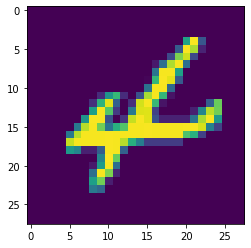

MNIST database example digit:  0


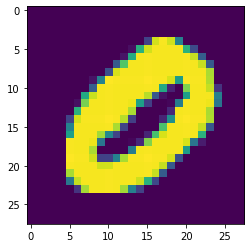

MNIST database example digit:  2


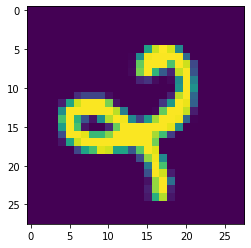

In [10]:
print_rand(dataset,3)

### Preprocess the dataset

In [11]:
from sklearn.model_selection import train_test_split

# divide preliminary dataset set into features and labels
X = dataset.drop(columns=["label"]) # features
y = dataset['label'] # labels

### Check Class distribution

{1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795}


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


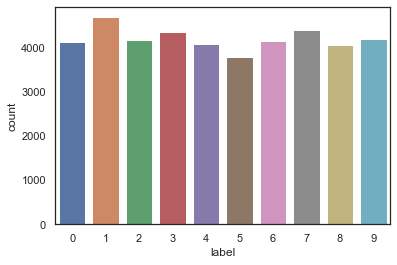

In [12]:
import seaborn as sns

sns.set(style='white', context='notebook', palette='deep')
# check whether class distribution is inbalanced in order to decide whether to use k-fold or stratified
print(dict(y.value_counts()))
g = sns.countplot(y)

In [13]:
print(dataset.shape)

(42000, 785)


### Check for null and missing values

In [14]:
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [15]:
y.isnull().any()

False

### Reshape the Dataset

In [16]:
IMAGE_RES = 28

# Reshape and normalize the dataset
X = X.values.reshape(-1,IMAGE_RES,IMAGE_RES,1)/255.

In [17]:
# split the dataset into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y) # 80 to 20% randomly

In [18]:
# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=112) # 90 to 10%

# Modelling

### Setup the Layers

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

### Set the model parameters

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [21]:
from keras.callbacks import ReduceLROnPlateau

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [22]:
from math import ceil

EPOCHS = 20 
BATCH_SIZE = 100
steps_per_epoch = ceil(X_train.shape[0]/BATCH_SIZE)

### Data Augmentation

In [23]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

### Train the model

In [24]:
from math import ceil
history = model.fit(X_train, y_train, epochs=EPOCHS, 
          #steps_per_epoch=ceil(X_train.shape[0]//BATCH_SIZE),
          steps_per_epoch=steps_per_epoch,
          verbose=2, callbacks=[learning_rate_reduction],
          validation_data = (X_val,y_val))

Epoch 1/20
303/303 - 12s - loss: 0.2841 - accuracy: 0.9178 - val_loss: 0.0780 - val_accuracy: 0.9762 - lr: 0.0010 - 12s/epoch - 40ms/step
Epoch 2/20
303/303 - 12s - loss: 0.0728 - accuracy: 0.9781 - val_loss: 0.0555 - val_accuracy: 0.9801 - lr: 0.0010 - 12s/epoch - 40ms/step
Epoch 3/20
303/303 - 12s - loss: 0.0474 - accuracy: 0.9855 - val_loss: 0.0525 - val_accuracy: 0.9845 - lr: 0.0010 - 12s/epoch - 39ms/step
Epoch 4/20
303/303 - 11s - loss: 0.0343 - accuracy: 0.9892 - val_loss: 0.0443 - val_accuracy: 0.9881 - lr: 0.0010 - 11s/epoch - 38ms/step
Epoch 5/20
303/303 - 12s - loss: 0.0257 - accuracy: 0.9918 - val_loss: 0.0396 - val_accuracy: 0.9866 - lr: 0.0010 - 12s/epoch - 40ms/step
Epoch 6/20
303/303 - 12s - loss: 0.0194 - accuracy: 0.9938 - val_loss: 0.0462 - val_accuracy: 0.9851 - lr: 0.0010 - 12s/epoch - 39ms/step
Epoch 7/20
303/303 - 12s - loss: 0.0166 - accuracy: 0.9950 - val_loss: 0.0448 - val_accuracy: 0.9857 - lr: 0.0010 - 12s/epoch - 38ms/step
Epoch 8/20
303/303 - 12s - loss: 0

### Evaluate the model

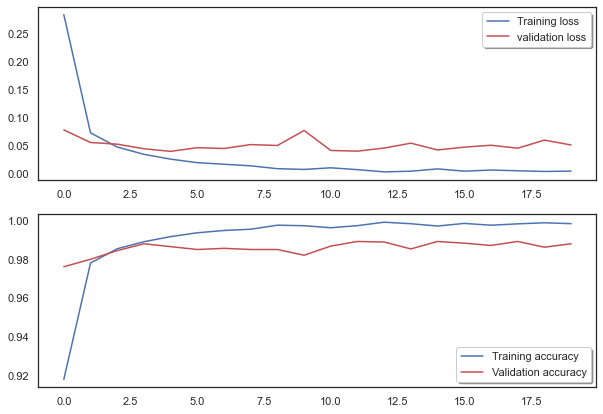

In [25]:
fig, ax = plt.subplots(2,1,figsize=(10,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [26]:
results = model.predict(X_test)
print(results.shape)

print(results[-1].argmax())
print(type(results[-1].argmax()))

print(y_test.shape[0])
print(y_test.iloc[-1])
print(type(y_test.iloc[-1]))
print(type(y_test))

263/263 [==============================] - 1s 5ms/step
(8400, 10)
2
<class 'numpy.int64'>
8400
2
<class 'numpy.int64'>
<class 'pandas.core.series.Series'>


### Predict the results

In [27]:
y_predict = model.predict(X_test)

263/263 [==============================] - 1s 5ms/step


### Evaluate the test accuracy

In [28]:
def acc_model(y_test, y_predict):
    if y_test.shape[0] != y_predict.shape[0]:
        print("Invalid Input, size of the arrays do not match!")
        return 0
    else:
        sum=0
        for i in range(y_test.shape[0]):
            if y_test.iloc[i] == y_predict[i].argmax():
                sum += 1
    return float("%.4f" % (sum/y_test.shape[0]*100))

In [29]:
accuracy = acc_model(y_test,y_predict)
accuracy

98.6667

### Predict Test Data

In [30]:
test_Data = pd.read_csv("./data/test.csv")

In [32]:
IMAGE_RES = 28

# Reshape and normalize the dataset
test_Data = test_Data.values.reshape(-1,IMAGE_RES,IMAGE_RES,1)/255.

In [34]:
# Export CNN Model Predictions
pred = model.predict(test_Data)
pred = np.argmax(pred, axis = 1) 

pd.read_csv("./data/sample_submission.csv")
df = pd.DataFrame({'ImageId':range(1,len(pred)+1),'Label':pred})
df.to_csv("submission4.csv",index=False)

875/875 [==============================] - 5s 5ms/step
